# Phase 3 - Modeling

**Note 1: the following starting code only generates a single random train/test split when default_seed is used. You need to modify the code to generate 100 independent train/test splits with different seeds and report the average results on those independent splits along with standard deviation.**

**Note 2: You are completely free to use your own implementation.**

In [16]:
# Load general utilities
# ----------------------
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
# from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [17]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [18]:
default_seed = 1
output_file = "output_sample"

In [19]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [20]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "../data/clean_data.pickle", "rb" ) )

In [21]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data['loan_status'].apply(lambda x: True if ((x == "Default") | (x == "Charged Off")) else False)

In [22]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [23]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], size = data.shape[0], p = [0.7, 0.3])

In [24]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

## Prepare functions to fit and evaluate models

In [25]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [26]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters, n_jobs = -1, scoring = 'roc_auc')
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [27]:
## define your set of features to use in different models
your_features = discrete_features + continuous_features
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Random Classifier

  Model: Random Classifier
Fit time: 0.86 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.78735
              precision    recall  f1-score   support

  No default     0.7873    1.0000    0.8810     15747
     Default     0.0000    0.0000    0.0000      4253

    accuracy                         0.7873     20000
   macro avg     0.3937    0.5000    0.4405     20000
weighted avg     0.6199    0.7873    0.6937     20000



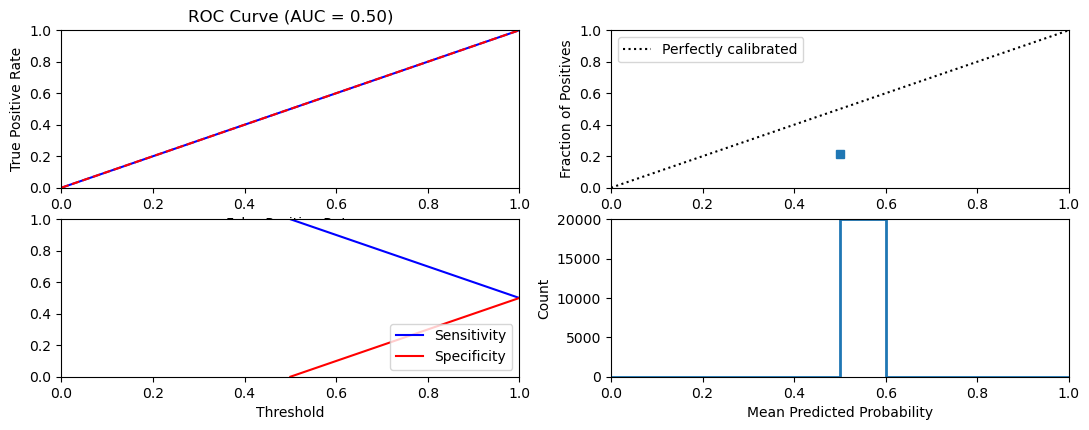


Similarity to LC grade ranking:  nan
Brier score: 0.25
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.5]


In [28]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform')
random_classifier=fit_classification(random_classifier,data_dict=data_dict,model_name = "Random Classifier")

### Naive Bayes

  Model: Naive Bayes
Fit time: 0.68 seconds
Optimal parameters:
{'var_smoothing': 0.3359818286283782}

Accuracy-maximizing threshold was: 0.7609481065912624
Accuracy:  0.78775
              precision    recall  f1-score   support

  No default     0.7916    0.9915    0.8803     15747
     Default     0.5145    0.0334    0.0627      4253

    accuracy                         0.7877     20000
   macro avg     0.6530    0.5124    0.4715     20000
weighted avg     0.7327    0.7877    0.7065     20000



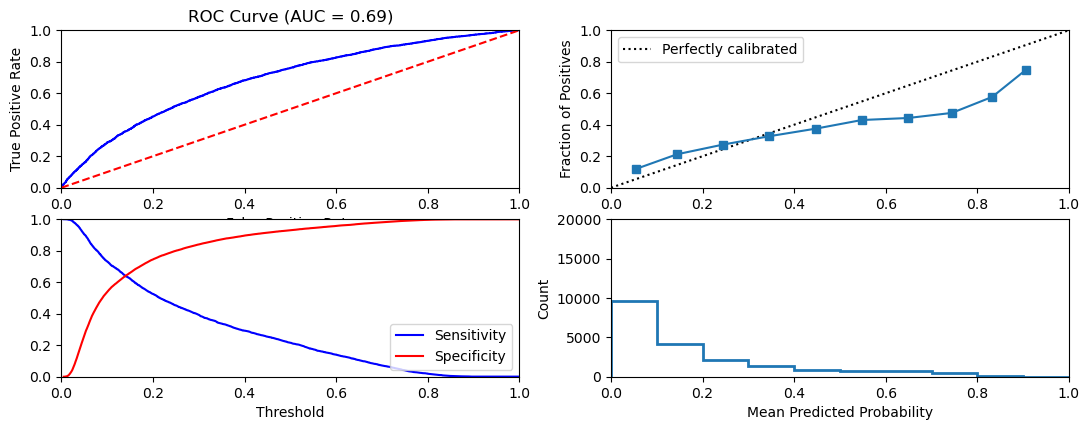


Similarity to LC grade ranking:  0.6780292736344544
Brier score: 0.16164877341233783
Were parameters on edge? : False
Score variations around CV search grid : 1.9278076652116385
[0.68838323 0.69101023 0.68973306 0.68494972 0.6802629  0.67819099
 0.67768889 0.67802826 0.67848709 0.67875297 0.67856361 0.67853542
 0.67852916 0.67853179 0.67854281 0.6785543  0.67854354 0.67850635
 0.67847733 0.67845031]


In [29]:
## Train and test a naive bayes classifier
gnb_param_grid = {
    'var_smoothing' : np.logspace(0,-9, num=20)
}
gnb = GaussianNB()
gnb = fit_classification(model = gnb, data_dict = data_dict,
                         cv_parameters = gnb_param_grid, model_name = "Naive Bayes")

### $l_1$ regularized logistic regression

/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-pack

  Model: L1-Logistic Regression
Fit time: 62.32 seconds
Optimal parameters:
{'C': 10, 'solver': 'saga'}

Accuracy-maximizing threshold was: 0.7983515554051198
Accuracy:  0.79025
              precision    recall  f1-score   support

  No default     0.7971    0.9841    0.8808     15747
     Default     0.5520    0.0724    0.1280      4253

    accuracy                         0.7903     20000
   macro avg     0.6745    0.5283    0.5044     20000
weighted avg     0.7450    0.7903    0.7207     20000



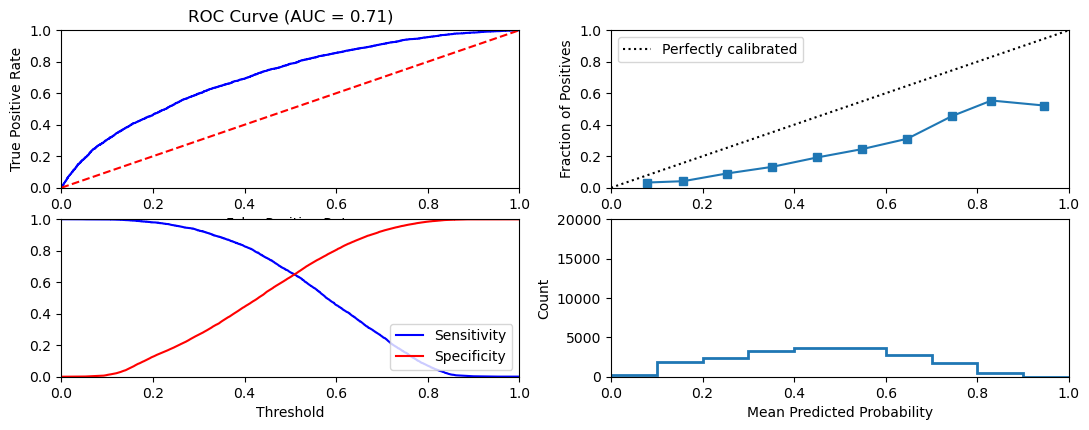


Similarity to LC grade ranking:  0.7341391368342275
Brier score: 0.21726927535443588
Were parameters on edge? : True
Score variations around CV search grid : 0.012500701467001834
[0.70630389 0.70628959 0.7063504  0.7063779  0.70632935 0.70636057
 0.70632253 0.70635944 0.7063338  0.70635937]


In [30]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1', class_weight = 'balanced')
cv_parameters = {
    'C' : [1, 10, 100, 300, 500],
    'solver' : ['liblinear', 'saga'],
}

l1_logistic = fit_classification(model = l1_logistic, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "L1-Logistic Regression")

### $l_2$ regularized logistic regression

/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

  Model: L2-Logistic Regression
Fit time: 10.57 seconds
Optimal parameters:
{'C': 300, 'solver': 'saga'}

Accuracy-maximizing threshold was: 0.7802733493770453
Accuracy:  0.79005
              precision    recall  f1-score   support

  No default     0.8006    0.9766    0.8799     15747
     Default     0.5341    0.0995    0.1677      4253

    accuracy                         0.7901     20000
   macro avg     0.6673    0.5380    0.5238     20000
weighted avg     0.7439    0.7901    0.7284     20000



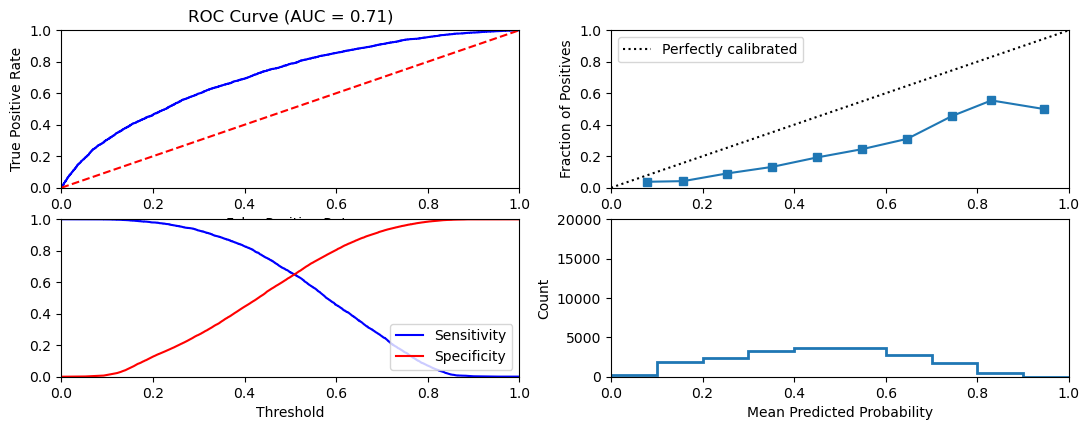


Similarity to LC grade ranking:  0.7336100246165369
Brier score: 0.217284684581909
Were parameters on edge? : True
Score variations around CV search grid : 0.287201325869202
[0.70441387 0.70433267 0.70437649 0.70437601 0.70576987 0.70619265
 0.70619302 0.70618487 0.70593415 0.70634646 0.70634598 0.7063559
 0.7062489  0.70633815 0.70633619 0.70636135 0.70600545 0.70633421
 0.70633489 0.70635546]


In [31]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2', class_weight = 'balanced')
cv_parameters = {
    'C' : [1, 10, 100, 300, 500],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
}

l2_logistic = fit_classification(model = l2_logistic, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "L2-Logistic Regression")

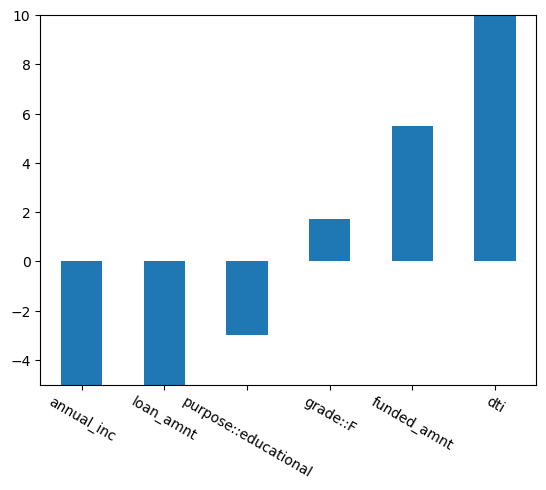

In [32]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: DT
Fit time: 2.22 seconds
Optimal parameters:
{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 20}

Accuracy-maximizing threshold was: 0.8031814380626734
Accuracy:  0.7879
              precision    recall  f1-score   support

  No default     0.7987    0.9769    0.8788     15747
     Default     0.5074    0.0882    0.1502      4253

    accuracy                         0.7879     20000
   macro avg     0.6531    0.5325    0.5145     20000
weighted avg     0.7367    0.7879    0.7239     20000



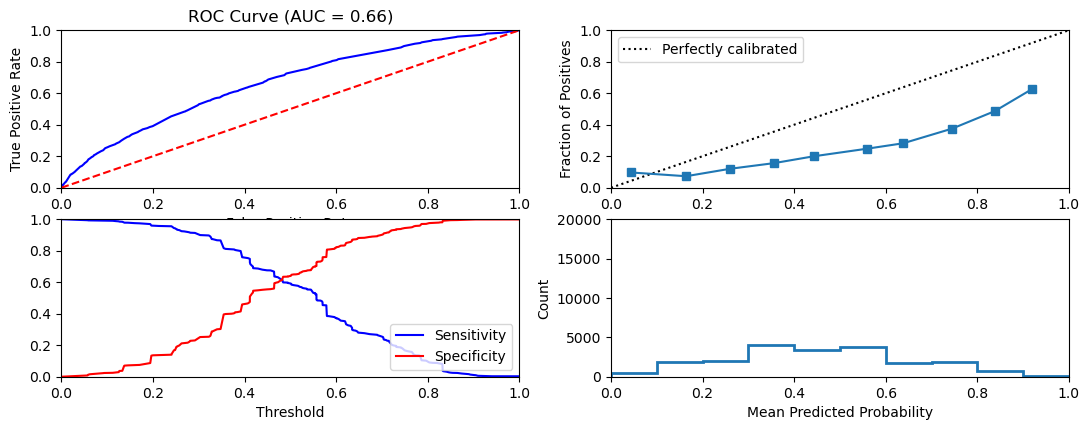


Similarity to LC grade ranking:  0.5779106190478636
Brier score: 0.22545000458675077
Were parameters on edge? : True
Score variations around CV search grid : 11.256769633910494
[0.64032142 0.64843731 0.65562058 0.65293942 0.65099648 0.64752193
 0.64084981 0.64198779 0.64935934 0.62137323 0.62860847 0.63247653
 0.61377937 0.62210772 0.63927948 0.59463346 0.60774335 0.62502719
 0.59729307 0.62562842 0.63966143 0.5893272  0.61711107 0.63436354
 0.58181888 0.59638907 0.62017512]


In [33]:
## Train and test a decision tree classifier

decision_tree = DecisionTreeClassifier(random_state=default_seed, class_weight='balanced')
cv_parameters = {
    'max_depth' : [10, 15, 20],
    'max_features' : ['log2','sqrt', None],
    'min_samples_leaf' : [5, 10, 20]
}

decision_tree = fit_classification(model = decision_tree, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "DT")

### Random forest

  Model: Random Forest
Fit time: 203.22 seconds
Optimal parameters:
{'max_depth': 10, 'max_features': 'log2', 'n_estimators': 300}

Accuracy-maximizing threshold was: 0.3565924576359983
Accuracy:  0.7862
              precision    recall  f1-score   support

  No default     0.8148    0.9427    0.8741     15747
     Default     0.4936    0.2069    0.2916      4253

    accuracy                         0.7862     20000
   macro avg     0.6542    0.5748    0.5828     20000
weighted avg     0.7465    0.7862    0.7502     20000



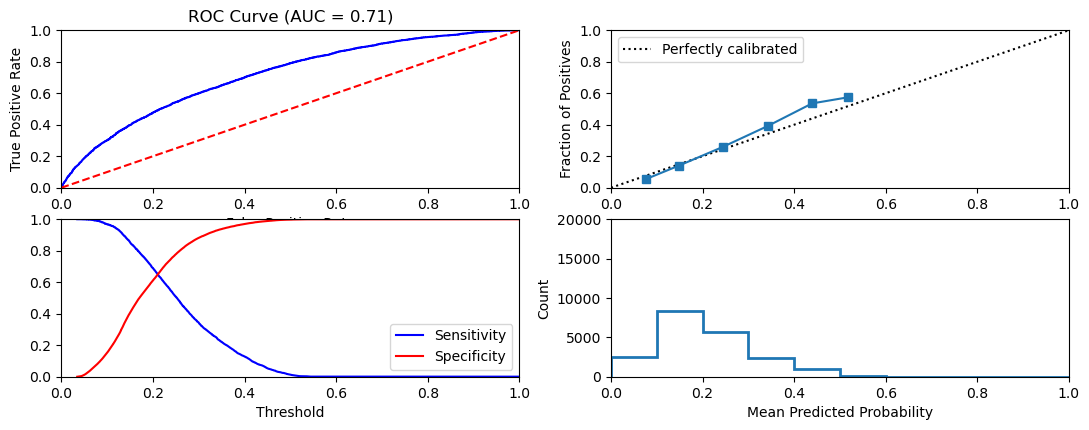


Similarity to LC grade ranking:  0.7377155961040696
Brier score: 0.1518593392535924
Were parameters on edge? : True
Score variations around CV search grid : 2.2568187860027744
[0.70258889 0.70230906 0.70282749 0.70262134 0.70193596 0.70201064
 0.6971176  0.69750544 0.69785769 0.70515936 0.70642334 0.70679851
 0.70598294 0.7066457  0.70672303 0.69824062 0.6995118  0.69984691
 0.70099251 0.70406043 0.70451119 0.70035423 0.70264611 0.70319679
 0.69084735 0.69298016 0.6933246 ]


In [34]:
## Train and test a random forest classifier

random_forest = RandomForestClassifier(random_state=default_seed)
cv_parameters = {
    'n_estimators' : [100, 200, 300],
    'max_depth' : [5, 10, 15],
    'max_features' : ['log2','sqrt', None],
}

random_forest = fit_classification(model = random_forest, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "Random Forest")

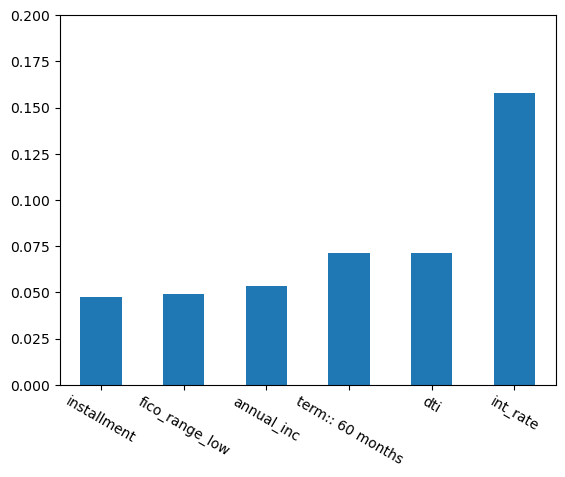

In [35]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/wirachlee/minicon

  Model: MLP
Fit time: 126.32 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'learning_rate': 'adaptive'}

Accuracy-maximizing threshold was: 0.45592698915574814
Accuracy:  0.7906
              precision    recall  f1-score   support

  No default     0.7974    0.9841    0.8810     15747
     Default     0.5573    0.0743    0.1311      4253

    accuracy                         0.7906     20000
   macro avg     0.6774    0.5292    0.5060     20000
weighted avg     0.7464    0.7906    0.7215     20000



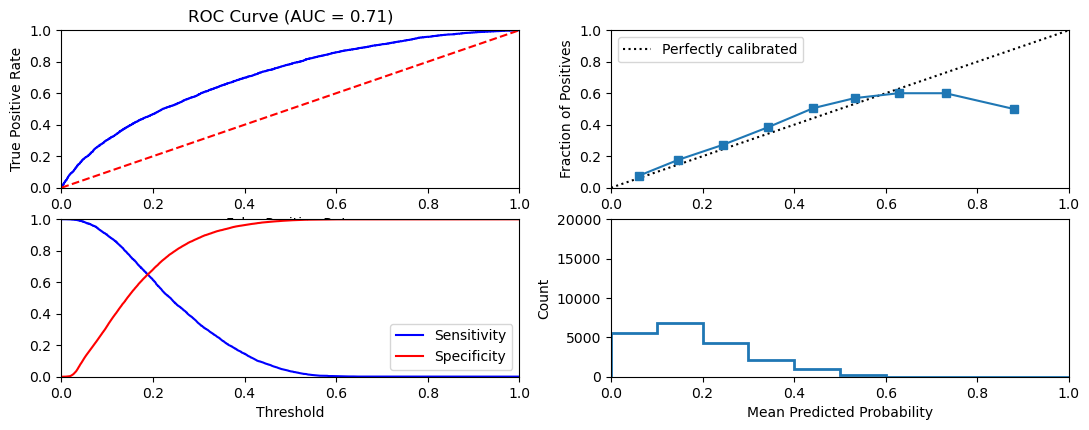


Similarity to LC grade ranking:  0.7488771456964143
Brier score: 0.15234546409272903
Were parameters on edge? : True
Score variations around CV search grid : 6.442618040118063
[0.70333694 0.70513895 0.70510285 0.70251827 0.70394709 0.70304942
 0.70085458 0.70102431 0.70070669 0.69961115 0.69980739 0.69979736
 0.70147765 0.69332626 0.69293463 0.70219744 0.69353625 0.69395982
 0.7013308  0.69764612 0.7007988  0.70058808 0.70031075 0.70112024
 0.69855327 0.67827664 0.65970954 0.69768594 0.6791195  0.66396639
 0.69663339 0.68551589 0.66716698 0.69952131 0.69782825 0.6952844 ]


In [36]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier(random_state=default_seed)
cv_parameters = {
    'hidden_layer_sizes': [(10,), (50,), (100,)],
    'activation' : ['logistic', 'tanh', 'relu'],
    'alpha' : [0.0001, 0.001, 0.01, 0.1],
    'learning_rate' : ['adaptive']
}

mlp = fit_classification(model = mlp, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "MLP")

## Train and Test logistic regression model with features derived by LendingClub

/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/wirachlee/miniconda/lib/python3.9/site-pack

  Model: L1-Logistic Regression w/ LC features only
Fit time: 67.38 seconds
Optimal parameters:
{'C': 10, 'solver': 'saga'}

Accuracy-maximizing threshold was: 0.7983515554051198
Accuracy:  0.79025
              precision    recall  f1-score   support

  No default     0.7971    0.9841    0.8808     15747
     Default     0.5520    0.0724    0.1280      4253

    accuracy                         0.7903     20000
   macro avg     0.6745    0.5283    0.5044     20000
weighted avg     0.7450    0.7903    0.7207     20000



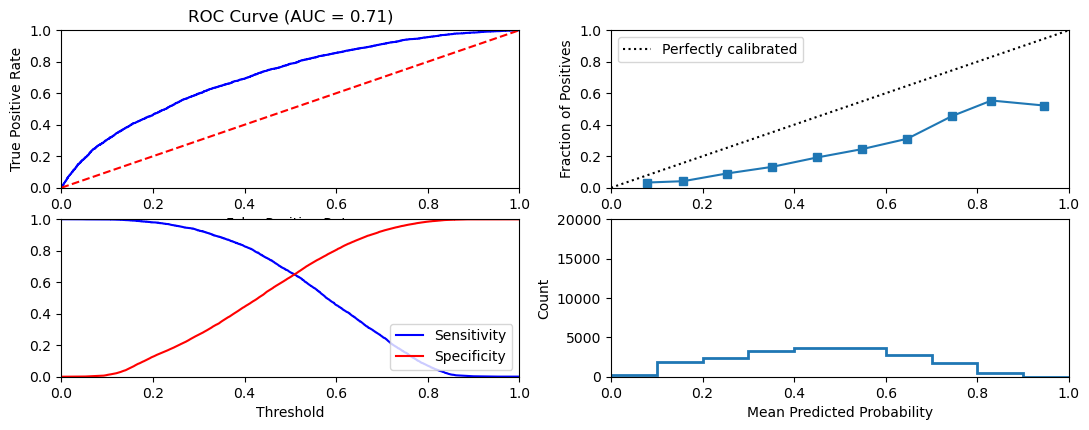


Similarity to LC grade ranking:  0.7341391368342275
Brier score: 0.21726927535443588
Were parameters on edge? : True
Score variations around CV search grid : 0.013179512587226121
[0.70630409 0.70628795 0.70635633 0.70638105 0.70632623 0.70636043
 0.70632421 0.70635937 0.7063168  0.70636036]


In [37]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['grade', 'verification_status', 'dti']
use_feature = ['grade']

lc_data_dict = prepare_data(feature_subset = use_feature)
lc1_only_logistic = LogisticRegression(penalty='l1', class_weight = 'balanced')
cv_parameters = {
    'C' : [1, 10, 100, 300, 500],
    'solver' : ['liblinear', 'saga'],
}

lc1_only_logistic = fit_classification(model = lc1_only_logistic ,data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "L1-Logistic Regression w/ LC features only")

  Model: L2-Logistic Regression w/ LC featuers only
Fit time: 0.87 seconds
Optimal parameters:
{'C': 10, 'solver': 'lbfgs'}

Accuracy-maximizing threshold was: 1
Accuracy:  0.78735
              precision    recall  f1-score   support

  No default     0.7873    1.0000    0.8810     15747
     Default     0.0000    0.0000    0.0000      4253

    accuracy                         0.7873     20000
   macro avg     0.3937    0.5000    0.4405     20000
weighted avg     0.6199    0.7873    0.6937     20000



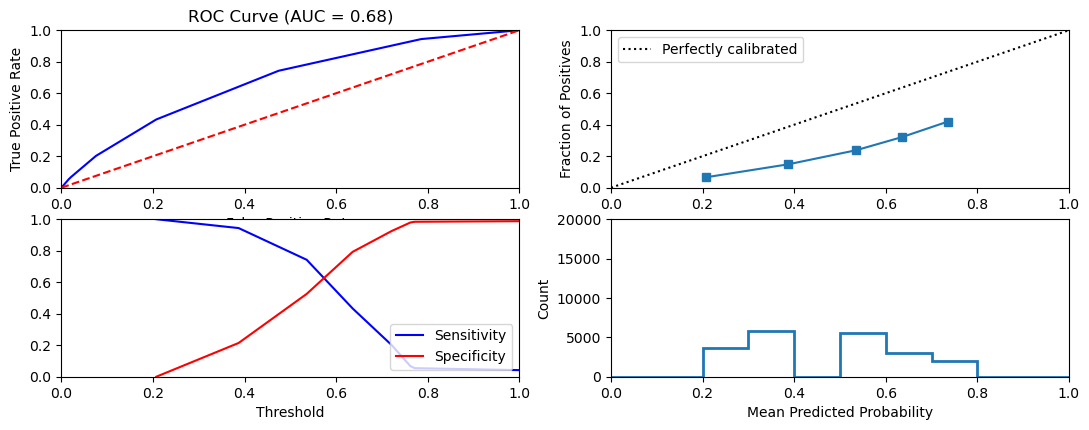


Similarity to LC grade ranking:  0.9992056684469759
Brier score: 0.2255705593200657
Were parameters on edge? : True
Score variations around CV search grid : 0.015609888209845652
[0.68106466 0.68106466 0.68106466 0.68106466 0.68117099 0.68117099
 0.68117099 0.68117099 0.68115829 0.68115829 0.68115829 0.68115829
 0.68115829 0.68115829 0.68115829 0.68115829 0.68115829 0.68115829
 0.68115829 0.68115829]


In [38]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2', class_weight = 'balanced')
cv_parameters = {
    'C' : [1, 10, 100, 300, 500],
    'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
}

lc2_only_logistic = fit_classification(model = lc2_only_logistic, data_dict = lc_data_dict,
                         cv_parameters = cv_parameters, model_name = "L2-Logistic Regression w/ LC featuers only")

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [39]:
performance_dict = {
    'gnb' : {'model' : gnb['model'], 'auc_score' : []},
    'l1_logistic' : {'model' : l1_logistic['model'], 'auc_score' : []},
    'l2_logistic' : {'model' : l2_logistic['model'], 'auc_score' : []},
    'decision_tree' : {'model' : decision_tree['model'], 'auc_score' : []},
    'random_forest' : {'model' : random_forest['model'], 'auc_score' : []},
    'mlp' : {'model' : mlp['model'], 'auc_score' : []}
}
model_list = [gnb['model'] , l1_logistic['model'], l2_logistic['model'], decision_tree['model'], random_forest['model'], mlp['model']]
remaining_features = list(set(continuous_features + discrete_features).difference(a_lendingclub_feature))

#should be 100
for seed in [*range(100)]:
    data_dict = prepare_data(feature_subset=remaining_features, n_samples_train = 10000,
                    n_samples_test = 2000,random_state = seed)
    # load data
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    for model_name in performance_dict.keys():
        model = performance_dict[model_name]['model']
        model.fit(X_train, y_train)
        score = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
        performance_dict[model_name]['auc_score'].append(score)
for k,v in performance_dict.items():
    mean = np.mean(v['auc_score'])
    std = np.std(v['auc_score'])
    print(f'AUC score of {k} = {mean:.3f} +/- {std:.3f}')

AUC score of gnb = 0.674 +/- 0.014
AUC score of l1_logistic = 0.694 +/- 0.013
AUC score of l2_logistic = 0.694 +/- 0.013
AUC score of decision_tree = 0.630 +/- 0.018
AUC score of random_forest = 0.696 +/- 0.014
AUC score of mlp = 0.693 +/- 0.013


# Asses YOURMODEL's score with the grades assigned by LC

  Model: YOURMODEL
Fit time: 30.58 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.3672194700730198
Accuracy:  0.7933
              precision    recall  f1-score   support

  No default     0.8154    0.9565    0.8803     15891
     Default     0.4908    0.1623    0.2440      4109

    accuracy                         0.7933     20000
   macro avg     0.6531    0.5594    0.5621     20000
weighted avg     0.7487    0.7933    0.7496     20000



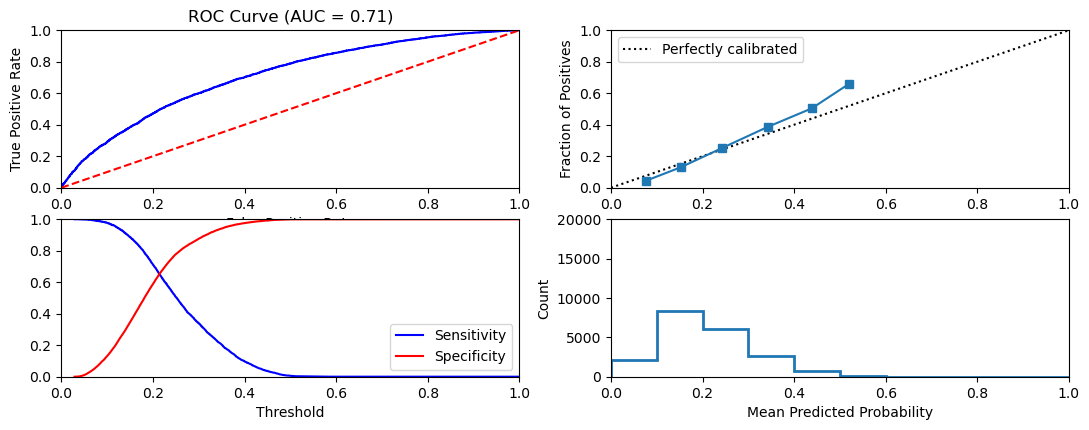


Similarity to LC grade ranking:  0.6853698005440626
Brier score: 0.14907048396135028
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.69891838]


In [40]:
data_dict = prepare_data(feature_subset=remaining_features, n_samples_train = 100000,
                    n_samples_test = 20000,random_state = seed)

## Train and test a random_forest_classifier

your_model = random_forest['model']

your_model = fit_classification(model = your_model, data_dict = data_dict, model_name = "YOURMODEL")

## Time stability test of YOURMODEL

## Train on 2010 test on 2018

  Model: Random Forest 2010
Fit time: 2.6 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.2356804369235481
Accuracy:  0.728
              precision    recall  f1-score   support

  No default     0.8031    0.8484    0.8251      2269
     Default     0.4295    0.3543    0.3883       731

    accuracy                         0.7280      3000
   macro avg     0.6163    0.6014    0.6067      3000
weighted avg     0.7121    0.7280    0.7187      3000



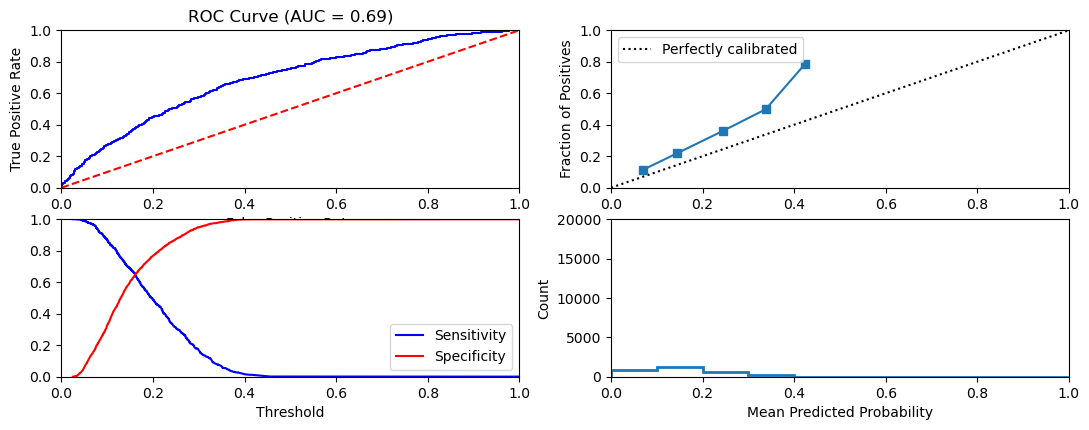


Similarity to LC grade ranking:  0.6563568961442546
Brier score: 0.17710935780199197
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.69933155]


In [41]:
## Define the time window of your train and test data
start_date_train = datetime.datetime.strptime('2010-01-01', '%Y-%m-%d').date()
end_date_train = datetime.datetime.strptime('2010-12-01', '%Y-%m-%d').date()
start_date_test = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d').date()
end_date_test = datetime.datetime.strptime('2018-12-01', '%Y-%m-%d').date()

remaining_features = list(set(continuous_features + discrete_features).difference(a_lendingclub_feature))
data_dict_2010 = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 3000, feature_subset = remaining_features)

rfc_2010 = fit_classification(model = random_forest['model'], data_dict = data_dict_2010, model_name = "Random Forest 2010")

## Train on 2017 test on 2018

  Model: Random Forest 2017
Fit time: 2.52 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.24732978790315377
Accuracy:  0.738
              precision    recall  f1-score   support

  No default     0.7568    0.9538    0.8439      2228
     Default     0.4635    0.1153    0.1846       772

    accuracy                         0.7380      3000
   macro avg     0.6102    0.5345    0.5143      3000
weighted avg     0.6813    0.7380    0.6743      3000



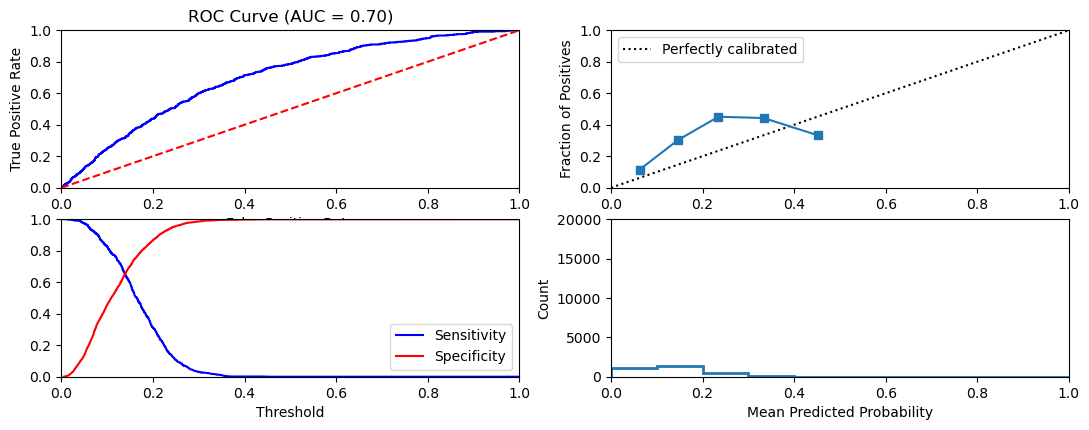


Similarity to LC grade ranking:  0.5769495123719924
Brier score: 0.1936703557242969
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.70474967]


In [42]:
## Define the time window of your train and test data
start_date_train = datetime.datetime.strptime('2017-01-01', '%Y-%m-%d').date()
end_date_train = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d').date()
start_date_test = datetime.datetime.strptime('2018-01-01', '%Y-%m-%d').date()
end_date_test = datetime.datetime.strptime('2018-12-01', '%Y-%m-%d').date()

data_dict_2017 = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 7000, n_samples_test = 3000, feature_subset = remaining_features)

rfc_2017 = fit_classification(model = random_forest['model'], data_dict = data_dict_2017, model_name = "Random Forest 2017")

## Train and test YOURMODEL on the original data

In [43]:
# Load general utilities
# ----------------------
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
# from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [44]:
# A helper function that you'll be using while reading the raw files
def is_integer(x):
    '''
    This function returns True if x is an integer, and False otherwise
    '''
    try:
        return (int(x) == float(x))
    except:
        return False
    
def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.
    
    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we 
    assume the files are zipped (pd.read_csv can read zipped files) 
    and we assume the first line in each file needs to be skipped.
    
    Note that each file will be read *without* formatting
    '''
    
    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += "/"
    
    all_files = os.listdir(directory) # get list of all files from the directory
    output = {}
    
    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory+i, dtype='str', skiprows=1) # read each with dtype='str' and skip_rows =1
        
        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = ~output[i]['id'].apply(lambda x: is_integer(x)) # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][~invalid_rows] # remove invalid rows
    
    return output # return dictionary of dataframe
    
# Define the directories that contain the files downloaded
dir_cs = "../data/2003_download/" # path to the directory where all the *.csv.zip files are located

In [45]:
cols_to_pick = ["id", "loan_amnt", "funded_amnt", "funded_amnt_inv", "term", "int_rate",
"installment", "grade", "sub_grade", "emp_title", "emp_length", "home_ownership", "annual_inc", "verification_status", "issue_d", "loan_status", "purpose", "title",
"zip_code", "addr_state", "dti", "total_pymnt", "delinq_2yrs", "earliest_cr_line", "open_acc", "pub_rec", "last_pymnt_d", "last_pymnt_amnt", "fico_range_high",
"fico_range_low", "last_fico_range_high", "last_fico_range_low", "application_type", "revol_bal", "revol_util", "recoveries"]

float_cols = ["loan_amnt", "funded_amnt", "funded_amnt_inv", "annual_inc", "dti", "delinq_2yrs", "open_acc", "pub_rec", "fico_range_high", "fico_range_low", "revol_bal", "total_pymnt", "recoveries", "installment",  "last_pymnt_amnt", "last_fico_range_high", "last_fico_range_low"]
cat_cols = ["term", "grade", "sub_grade",  "emp_length", "emp_title", "title", "zip_code", "addr_state", "home_ownership", "verification_status" , "loan_status", "purpose", "application_type"] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

In [46]:
# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = cat_cols

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

In [47]:
# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

data_cs = (pd.concat([data for data in files_cs.values()])  # combine "files_cs" into a pandas dataframe
             .reset_index(drop=True)) # resent index with drop = True

# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick]

Directory ../data/2003_download/ has 20 files:
    Reading file LoanStats_securev1_2019Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2018Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Fo

In [48]:
# Remember that we read the data as string (without any formatting). 
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

for i in float_cols:
    final_data[i] = final_data[i].astype(float) # typecast float columns

def clean_perc(x):
    if pd.isnull(x):
        return np.nan
    else:
        return float(x.strip()[:-1])

def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.datetime.strptime( x, "%b-%Y").date()
    
for i in perc_cols:
    final_data[i] = final_data[i].apply(lambda x: clean_perc(x)) # apply clean_perc to percentage columns

for i in date_cols:
    final_data[i] = final_data[i].apply(lambda x: clean_date(x)) # typecast date cloumns to datatime using clean_date

for i in cat_cols:
    final_data[i] = final_data[i].apply(lambda x: None if pd.isnull(x) else x) # for categorical features if the value is null/empty set it to None

# Remove all loans that are still current

final_data = final_data[(final_data.loan_status.isin(['Fully Paid', 'Charged Off', 'Default']))]


In [49]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
final_data["outcome"] = final_data['loan_status'].apply(lambda x: True if ((x == "Default") | (x == "Charged Off")) else False)

# Deal with null values. We allow cateogrical variables to be null
# OTHER than grade, which is a particularly important categorical.
# All non-categorical variables must be non-null, and we drop
# rows that do not meet this requirement

required_cols = set(cols_to_pick) - set(cat_cols) - set(["id"])
required_cols.add("grade")

final_data.replace([np.inf, -np.inf], np.nan, inplace=True)

n_rows = len(final_data)

final_data = final_data.dropna(subset=required_cols) # drop rows that contain null based only on "required_cols"

print("Removed " + str(n_rows - len(final_data)) + " rows")

Removed 4505 rows


In [50]:
from sklearn.preprocessing import OneHotEncoder
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler
from sklearn.neural_network import MLPClassifier

default_seed = 0
np.random.seed(default_seed)

#subset the data to reduce runtime
# final_data = final_data.sample(n = 200000, random_state = default_seed)

# Continuous features
X_continuous = final_data[continuous_features].values
# Discrete features
encoder = OneHotEncoder(sparse=True)
X_discrete = encoder.fit_transform(final_data[discrete_features + date_cols])

# concat both feature matrices
X = hstack((X_continuous, X_discrete))

y = final_data.outcome.values

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)
# use MaxAbsScaler instead of MinMaxScaler to handle sparse matrix
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
## Train and test a Random Forest classifier
rfc_original_features = RandomForestClassifier(max_depth = 10, max_features='log2', n_estimators=300, random_state=default_seed, class_weight = 'balanced')
rfc_original_features.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       max_features='log2', n_estimators=300, random_state=0)

In [52]:
# evaluate
y_pred = rfc_original_features.predict(X_test)
print(classification_report(y_pred,y_test))
score = roc_auc_score(y_test, rfc_original_features.predict_proba(X_test)[:,1])
print(f"AUC ROC score = {score}")
print(f"Accuracy = {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

       False       0.99      1.00      1.00    272046
        True       0.99      0.97      0.98     72365

    accuracy                           0.99    344411
   macro avg       0.99      0.99      0.99    344411
weighted avg       0.99      0.99      0.99    344411

AUC ROC score = 0.9997226550272984
Accuracy = 0.9930083533917325


Text(0.5, 0, 'False Positive Rate')

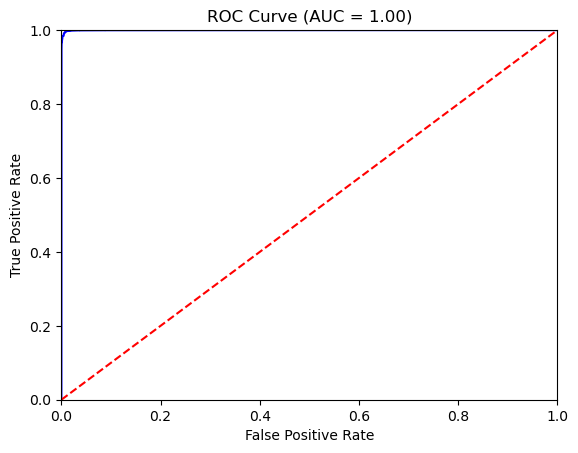

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, rfc_original_features.predict_proba(X_test)[:,1], pos_label=1)

plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, rfc_original_features.predict_proba(X_test)[:,1]))
plt.plot(fpr, tpr, 'b')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1]); plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Test regression models

In [ ]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].to_numpy()
        y_test = data.loc[filter_test, ret_col].to_numpy()

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

### $l_1$ regularized linear regression

In [ ]:
## First, trying l1 regularized linear regression with hyper-parameters
lasso_regression  = linear_model.Lasso()
cv_parameters = {'alpha': [0.0001, 0.001, 0.01]}

reg_lasso = fit_regression(model = lasso_regression, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "Lasso linear Regression")

  Model: Lasso linear Regression  Return column: ret_PESS
Fit time: 7.64 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.02842645570334945
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -121.857955914158
All test scores : [-0.01418543 -0.02159929 -0.0314715 ]
  Model: Lasso linear Regression  Return column: ret_OPT
Fit time: 9.61 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.020098403239693696
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 165.8153079173877
All test scores : [ 0.01142613  0.00150699 -0.00752015]
  Model: Lasso linear Regression  Return column: ret_INTa
Fit time: 4.27 seconds
Optimal parameters:
{'alpha': 0.0001}

Testing r2 score: 0.03206570479467985
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -240.23017978898272
All test scores : [-0.0080591  -0.01449818 -0.02741948]
  Model: Lasso linear Regression  Retu

In [ ]:
reg_lasso_sep = fit_regression(model = lasso_regression, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "Lasso linear Regression", separate = True)

  Model: Lasso linear Regression  Return column: ret_PESS
Fit time: 4.98 seconds
Optimal parameters:
model_0: {'alpha': 0.0001} model_1 {'alpha': 0.0001}

Testing r2 scores:
model_0: 0.2686719736627774
model_1: 0.15446878431637867
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 163.4287042059403
All test scores : [ 0.16579882  0.06748478 -0.10516404]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -493.0619870190423
All test scores : [-0.02273972 -0.03949749 -0.13486065]
  Model: Lasso linear Regression  Return column: ret_OPT
Fit time: 2.34 seconds
Optimal parameters:
model_0: {'alpha': 0.0001} model_1 {'alpha': 0.0001}

Testing r2 scores:
model_0: 0.7070268876277859
model_1: 0.14848831011472685
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 100.59878836558103
All test scores : [ 0.69574649  0.68025116 -0.00416605]
Were parameters on edge (model_1) : Tru

### $l_2$ regularized linear regressor

In [ ]:
## trying l2 regularized linear regression with hyper-parameters
ridge_regression  = linear_model.Ridge()
cv_parameters = {'alpha': [ 10, 100, 200]}

reg_ridge = fit_regression(model = ridge_regression, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "Ridge linear Regression")

  Model: Ridge linear Regression  Return column: ret_PESS
Fit time: 0.55 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.03221808344781163
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -6.653046877394461
All test scores : [-0.01233784 -0.01315868 -0.01299018]
  Model: Ridge linear Regression  Return column: ret_OPT
Fit time: 0.49 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.022620202871312722
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 44.05700244429576
All test scores : [0.01347912 0.00878513 0.00754062]
  Model: Ridge linear Regression  Return column: ret_INTa
Fit time: 0.49 seconds
Optimal parameters:
{'alpha': 10}

Testing r2 score: 0.03731848475444077
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -50.17189201860142
All test scores : [-0.00412765 -0.00616387 -0.00619857]
  Model: Ridge linear Regression  Return column: ret_

In [ ]:
reg_ridge_sep = fit_regression(model = ridge_regression, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "Ridge linear Regression", separate = True)

  Model: Ridge linear Regression  Return column: ret_PESS
Fit time: 0.52 seconds
Optimal parameters:
model_0: {'alpha': 100} model_1 {'alpha': 10}

Testing r2 scores:
model_0: 0.2787812903075174
model_1: 0.15683425539227014
Were parameters on edge (model_0) : False
Score variations around CV search grid (model_0) : 2.221344695953686
All test scores : [0.17068999 0.17456774 0.17099525]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -58.09233691144702
All test scores : [-0.02140376 -0.02878536 -0.0338377 ]
  Model: Ridge linear Regression  Return column: ret_OPT
Fit time: 0.47 seconds
Optimal parameters:
model_0: {'alpha': 10} model_1 {'alpha': 10}

Testing r2 scores:
model_0: 0.7084955031011123
model_1: 0.15078874248666796
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 4.149780659077096
All test scores : [0.69474144 0.68319847 0.66591119]
Were parameters on edge (model_1) : True
Score variations ar

### Multi-layer perceptron regressor

In [ ]:
## trying multi-layer perceptron regression with hyper-parameters
mlp_regression = MLPRegressor(max_iter = 30, learning_rate_init= 0.0005, batch_size = 500) 

cv_parameters =  {'hidden_layer_sizes': [(10,), (50,), (100,)],
    'alpha' : [1, 10, 100]}

reg_mlp = fit_regression(model = mlp_regression, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "Multi-layer perceptron Regression")

  Model: Multi-layer perceptron Regression  Return column: ret_PESS
Fit time: 110.64 seconds
Optimal parameters:
{'alpha': 1, 'hidden_layer_sizes': (100,)}

Testing r2 score: 0.027392682723294093
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -792.6496806762174
All test scores : [-0.08666687 -0.02330891 -0.00970895 -0.03927592 -0.01935694 -0.02875919
 -0.02852532 -0.03768236 -0.03948625]
  Model: Multi-layer perceptron Regression  Return column: ret_OPT
Fit time: 98.05 seconds
Optimal parameters:
{'alpha': 1, 'hidden_layer_sizes': (100,)}

Testing r2 score: 0.01837885071570533
Were parameters on edge (model) : True
Score variations around CV search grid (model) : 1713.0767185152413
All test scores : [-0.03911705  0.00566917  0.00843652 -0.02755934 -0.00524376 -0.00408852
 -0.13608761 -0.00799801 -0.00846641]
  Model: Multi-layer perceptron Regression  Return column: ret_INTa
Fit time: 93.69 seconds
Optimal parameters:
{'alpha': 1, 'hidden_layer_

In [ ]:
reg_mlp_sep = fit_regression(model = mlp_regression, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "Multi-layer perceptron Regression", separate = True)

  Model: Multi-layer perceptron Regression  Return column: ret_PESS
Fit time: 96.81 seconds
Optimal parameters:
model_0: {'alpha': 1, 'hidden_layer_sizes': (100,)} model_1 {'alpha': 10, 'hidden_layer_sizes': (100,)}

Testing r2 scores:
model_0: 0.2666620820717357
model_1: 0.057144190991991306
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 1014.9230488290045
All test scores : [-1.6081343   0.07068677  0.17576716 -1.53807434 -0.01119674 -0.10377874
 -0.9170209  -0.09111671 -0.10128669]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -3675.785255842268
All test scores : [-4.0419121  -0.31697265 -0.14294143 -1.7344089  -0.43861661 -0.11067345
 -4.1787918  -0.85654296 -0.27599782]
  Model: Multi-layer perceptron Regression  Return column: ret_OPT
Fit time: 95.19 seconds
Optimal parameters:
model_0: {'alpha': 1, 'hidden_layer_sizes': (50,)} model_1 {'alpha': 1, 'hidden_layer_sizes': (100,)}

Testing r2 s

### Random forest regressor

In [ ]:
## trying random forest regression with hyper-parameters
rf_regression = RandomForestRegressor()
cv_parameters = {'n_estimators': [5, 10], 'max_depth': [10, 20]}

reg_rf = fit_regression(model = rf_regression, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "Random Forest Regression")

  Model: Random Forest Regression  Return column: ret_PESS
Fit time: 38.92 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 10}

Testing r2 score: 0.026201131945335465
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -469.63890182886206
All test scores : [-0.04645103 -0.02887582 -0.16448791 -0.10037521]
  Model: Random Forest Regression  Return column: ret_OPT
Fit time: 38.47 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 10}

Testing r2 score: 0.014229295250469898
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -2777.3300094260585
All test scores : [-0.02246762 -0.00555341 -0.15978994 -0.0758115 ]
  Model: Random Forest Regression  Return column: ret_INTa
Fit time: 38.93 seconds
Optimal parameters:
{'max_depth': 10, 'n_estimators': 10}

Testing r2 score: 0.028124847945926734
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -967.2761167821046

In [ ]:
reg_rf_sep = fit_regression(model = rf_regression, data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "Random Forest Regression", separate = True)

  Model: Random Forest Regression  Return column: ret_PESS
Fit time: 36.87 seconds
Optimal parameters:
model_0: {'max_depth': 10, 'n_estimators': 10} model_1 {'max_depth': 10, 'n_estimators': 10}

Testing r2 scores:
model_0: 0.34936470329916236
model_1: 0.1366564025066116
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 53.801738247743415
All test scores : [0.19642842 0.22039414 0.10181826 0.17307192]
Were parameters on edge (model_1) : True
Score variations around CV search grid (model_1) : -330.81186542637676
All test scores : [-0.09317223 -0.05219228 -0.22485054 -0.14651961]
  Model: Random Forest Regression  Return column: ret_OPT
Fit time: 36.88 seconds
Optimal parameters:
model_0: {'max_depth': 10, 'n_estimators': 10} model_1 {'max_depth': 10, 'n_estimators': 10}

Testing r2 scores:
model_0: 0.7138723829618236
model_1: 0.1319387817339297
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 7.6681350

## Test investment strategies (Part 8)
Now we test several investment strategies using the learning models above
Based on our analysis above, we will use mlp as our best classifier, and use random forest as our best regressor.

In [270]:
# implement each of the investment strategies described above using the best performing regressor from part 7
best_regressor = reg_rf

In [265]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.head(num_loans)

            ## Find the average return for these loans
            ## Calculate weighted average return
            ret_test = np.dot(pf_test[ret_col], pf_test.funded_amnt) / np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.head(num_loans)

            ## Find their return
            ret_test = np.dot(pf_test[ret_col], pf_test.funded_amnt) / np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            y_pred_score = classifier['y_pred_probs']
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.head(num_loans)

            ## Find the average return for these loans
            ret_test = np.dot(pf_test[ret_col], pf_test.funded_amnt) / np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.head(num_loans)

            ## Find their return
            ret_test = np.dot(pf_test[ret_col], pf_test.funded_amnt) / np.sum(pf_test.funded_amnt)

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

(i) Suppose you were to invest in 1000 loans using each of the four strategies, what would your returns be? Average your results over 100 independent train/test splits.

In [266]:
# initialize dataframe to record results for all strategies
col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
results_df = pd.DataFrame(columns=['Strategy'] + col_list)

### Strategy 1: Random

In [268]:
## Test investment strategies using the best performing regressor
test_strategy = 'Random'
results_random = {col: [] for col in col_list}
print('strategy:',test_strategy)   

for i in range(100):
    np.random.seed(i)
    temp_data_dict = prepare_data(random_state=i)
    strat_rand = test_investments(data_dict=temp_data_dict,
                                  strategy=test_strategy,
                                  num_loans=1000)
    # Append the results to the corresponding lists in the dictionary
    for col in col_list:
        results_random[col].append(strat_rand[col]['average return'])

# Calculate and print the mean for each list in the dictionary
average_results = {}

for col in col_list:
    average_result = np.mean(results_random[col])
    print(col + ': ' + str(average_result))
    average_results[col] = average_result

# Append the row to the DataFrame
results_df = results_df.append({'Strategy': test_strategy, **average_results}, ignore_index=True)

strategy: Random
ret_PESS: -0.000978968523582932
ret_OPT: 0.05030354552975233
ret_INTa: 0.018858956040829284
ret_INTb: 0.03358244001245926


### Strategy 2: Default-based

In [276]:
test_strategy = 'Default-based'
results_def = {col: [] for col in col_list}

print('strategy:',test_strategy)   

for i in range(100):
    np.random.seed(i)
    temp_data_dict = prepare_data(random_state=i)
    strat_rand = test_investments(data_dict=temp_data_dict,
                                  classifier=random_forest,
                                  strategy=test_strategy,
                                  num_loans=1000)
    # Append the results to the corresponding lists in the dictionary
    for col in col_list:
        results_def[col].append(strat_rand[col]['average return'])

# Calculate and print the mean for each list in the dictionary
average_results = {}

for col in col_list:
    average_result = np.mean(results_def[col])
    print(col + ': ' + str(average_result))
    average_results[col] = average_result

# Append the row to the DataFrame
results_df = results_df.append({'Strategy': test_strategy, **average_results}, ignore_index=True)

strategy: Default-based
ret_PESS: -0.0038504895698332326
ret_OPT: 0.05242868695026783
ret_INTa: 0.018564687684680573
ret_INTb: 0.03414222692529684


### Strategy 3: Return-based

In [277]:
test_strategy = 'Return-based'
results_ret = {col: [] for col in col_list}

print('strategy:',test_strategy)   

for i in range(100):
    np.random.seed(i)
    temp_data_dict = prepare_data(random_state=i)
    strat_rand = test_investments(data_dict=temp_data_dict,
                                  regressor=best_regressor,
                                  strategy=test_strategy,
                                  num_loans=1000)
    # Append the results to the corresponding lists in the dictionary
    for col in col_list:
        results_ret[col].append(strat_rand[col]['average return'])

# Calculate and print the mean for each list in the dictionary
for col in col_list:
    average_result = np.mean(results_ret[col])
    print(col + ': ' + str(average_result))
    average_results[col] = average_result

# Append the row to the DataFrame
results_df = results_df.append({'Strategy': test_strategy, **average_results}, ignore_index=True)

strategy: Return-based
ret_PESS: 0.013190842758255626
ret_OPT: 0.050600484848963886
ret_INTa: 0.01863878081374258
ret_INTb: 0.035096517282187475


### Strategy 4: Default-return based

In [278]:
# DO NOT DELETE! this is for def-ret strategy
cv_parameters = {'min_samples_leaf':[25, 75, 100, 200, 300],'n_estimators': [25, 50, 75, 100] }

reg_separate = fit_regression(model = RandomForestRegressor(), data_dict = data_dict,
                         cv_parameters = cv_parameters, model_name = "Random Forest Regression", separate = True)

  Model: Random Forest Regression  Return column: ret_PESS
Fit time: 462.41 seconds
Optimal parameters:
model_0: {'min_samples_leaf': 25, 'n_estimators': 100} model_1 {'min_samples_leaf': 25, 'n_estimators': 100}

Testing r2 scores:
model_0: 0.3720309250676449
model_1: 0.16783056298563515
{'model_0': RandomForestRegressor(min_samples_leaf=25), 'model_1': RandomForestRegressor(min_samples_leaf=25), 'predicted_regular_return': array([0.02732585, 0.04494077, 0.02512953, ..., 0.0411924 , 0.0453756 ,
       0.05394736]), 'predicted_default_return': array([-0.15122779, -0.19433379, -0.12042989, ..., -0.18566462,
       -0.16902371, -0.15094633]), 'r2_scores': {'model_0': 0.3720309250676449, 'model_1': 0.16783056298563515}}
Were parameters on edge (model_0) : True
Score variations around CV search grid (model_0) : 18.177937891195345
All test scores : [0.23008292 0.23331035 0.23338963 0.2358418  0.21007878 0.21252098
 0.21285197 0.21415173 0.20367464 0.20388893 0.20543057 0.20651903
 0.1930965

In [279]:
test_strategy = 'Default-return-based'
results_defret = {col: [] for col in col_list}

print('strategy:',test_strategy)   

for i in range(100):
    np.random.seed(i)
    temp_data_dict = prepare_data(random_state=i)
    strat_defret = test_investments(data_dict=temp_data_dict, 
                                    strategy = test_strategy, 
                                    classifier = random_forest,
                                    regressor = reg_separate, 
                                    num_loans = 1000)
    # Append the results to the corresponding lists in the dictionary
    for col in col_list:
        results_defret[col].append(strat_rand[col]['average return'])

# Calculate and print the mean for each list in the dictionary
for col in col_list:
    average_result = np.mean(results_defret[col])
    print(col + ': ' + str(average_result))
    average_results[col] = average_result

# Append the row to the DataFrame
results_df = results_df.append({'Strategy': test_strategy, **average_results}, ignore_index=True)

strategy: Default-return-based
ret_PESS: 0.015705725548724174
ret_OPT: 0.04666850552344487
ret_INTa: 0.02036721587480728
ret_INTb: 0.03959254193260498


In [283]:
results_df

,Strategy,ret_PESS,ret_OPT,ret_INTa,ret_INTb
1,Random,-0.000979,0.050304,0.018859,0.033582
2,Default-based,-0.003850,0.052429,0.018565,0.034142
3,Return-based,0.013191,0.050600,0.018639,0.035097
4,Default-return-based,0.015706,0.046669,0.020367,0.039593


## Sensitivity test of portfolio size (Part 9)

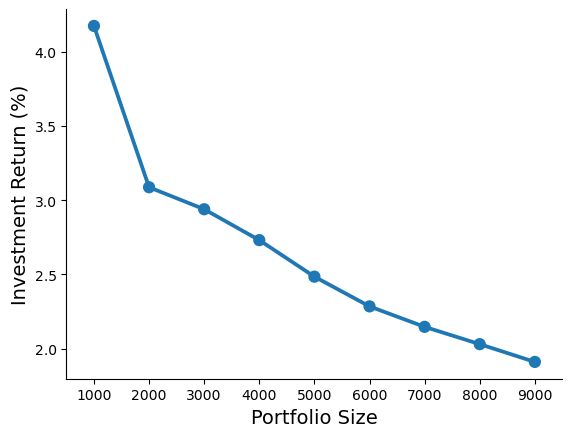

In [288]:
## Test the best-performing data-driven strategy on different portfolio sizes
result_sensitivity = []
## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):
    reg_0 = test_investments(data_dict=data_dict, 
                             regressor = reg_separate, 
                             classifier = random_forest, 
                             strategy = 'Default-return-based', 
                             num_loans = num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100 
sns.pointplot(x = np.array(list(range(1000,10000,1000))),y = result_sensitivity) 
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()